# Inference for SPIN

In [169]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from models.hourglas_spin import HourglassNet

# Load Model and Test Iference

In [151]:
channel_mean = [125.78279375, 130.15193705, 130.92051354]
channel_std = [52.71067801, 49.9758017,  48.39758796]

PATCH_SIZE = 16  # pixels per side of square patches
VAL_SIZE = 10  # size of the validation set (number of images)
CUTOFF = 0.25  # minimum average brightness for a mask patch to be classified as containing road

In [189]:
def normalize_img(img):    
    transform = nn.Sequential(
        transforms.Normalize(channel_mean, channel_std),
    )
    return transform(img)

def denormalize_img(img):    
    img = np.array(img, dtype=np.float32)
    for c in range(3):
        img[:, :, c] = (img[:, :, c] * channel_std[c]) + channel_mean[c]

    # plt.imshow(np.array(img, dtype=np.uint8))
    # plt.show()

    return img

def plot_inference(model, img, true_mask=None):
    img_tens = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
    img_tens = normalize_img(img_tens)
    mask = model(img_tens)[0][-1].softmax(axis=1).argmax(axis=1)[0, :, :].numpy()

    if not true_mask is None:
        fig, ax = plt.subplots(1, 4, figsize=(15, 5))
        true_img = img.copy()
        true_img[true_mask == 0] = true_img[true_mask == 0] * 0.5
        ax[0].imshow(np.array(true_img, dtype=np.uint8))

        ax[1].imshow(true_mask, cmap="gray")
        ax[2].imshow(mask, cmap="gray")

        img[mask == 0] = img[mask == 0] * 0.5
        ax[3].imshow(np.array(img, dtype=np.uint8))

        ax[0].set_title("Image")
        ax[1].set_title("True Mask")
        ax[2].set_title("Mask")
        ax[3].set_title("Masked Image")
        plt.show()
    
    else:
        fig, ax = plt.subplots(1, 3, figsize=(10, 5))
        ax[0].imshow(np.array(img, dtype=np.uint8))
        ax[1].imshow(mask, cmap="gray")

        img[mask == 0] = img[mask == 0] * 0.5
        ax[2].imshow(np.array(img, dtype=np.uint8))

        ax[0].set_title("Image")
        ax[1].set_title("Mask")
        ax[2].set_title("Masked Image")


        plt.show()

def save_inference(model, img, fpath):
    img_tens = torch.tensor(img).permute(2, 0, 1).unsqueeze(0)
    img_tens = normalize_img(img_tens)
    mask = model(img_tens)[0][-1].softmax(axis=1).argmax(axis=1)[0, :, :].numpy() * 255
    mask = Image.fromarray(mask.astype(np.uint8))
    mask.save(fpath)

def patch_accuracy_fn(y_hat, y):
    # computes accuracy weighted by patches (metric used on Kaggle for evaluation)
    h_patches = y.shape[-2] // PATCH_SIZE
    w_patches = y.shape[-1] // PATCH_SIZE
    patches_hat = (
        y_hat.reshape(-1, 1, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE).mean((-1, -3)) > CUTOFF
    )
    patches = y.reshape(-1, 1, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE).mean((-1, -3)) > CUTOFF
    return (patches == patches_hat).float().mean()

In [190]:
epoch = 100
checkpoint_path = "/Users/alexanderveicht/Desktop/Coding/cil-road-segmentation.nosync/checkpoints/spin_norm_loss"
# model_path = os.path.join(checkpoint_path, "models/model_{epoch}.pth")
model_path = os.path.join(checkpoint_path, "models/best_model.pth")

/var/folders/vn/89j8g3p55gb71ngxshtbg1r80000gn/T/ipykernel_39941/1789045623.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tens = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)


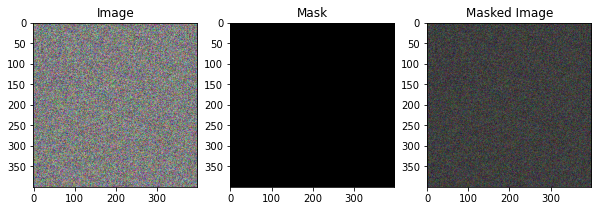

In [191]:
state_dict = torch.load(model_path, map_location=torch.device("cpu"))
model = HourglassNet()
model.load_state_dict(state_dict=state_dict)
model.eval()
x = torch.tensor(np.random.random(size=(400, 400, 3)), dtype=torch.float32) * 255

plot_inference(model, x)

# Evaluate model on val data

In [192]:
img_path = "/Users/alexanderveicht/Desktop/Coding/cil-road-segmentation.nosync/data/big-dataset/CIL"
val_df = pd.read_csv(os.path.join(checkpoint_path, "val_dataset.csv"))

0.656000018119812


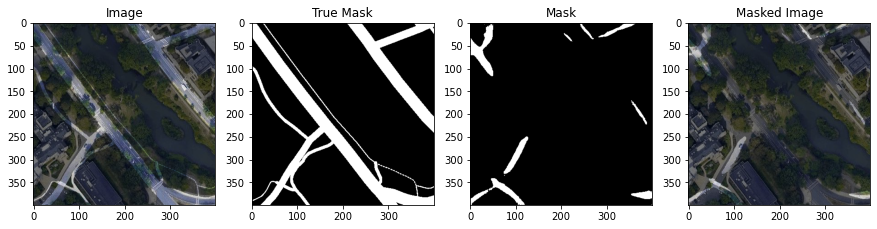

0.8095999956130981


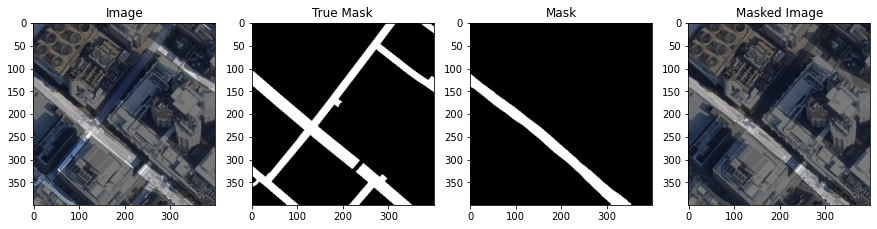

0.8623999953269958


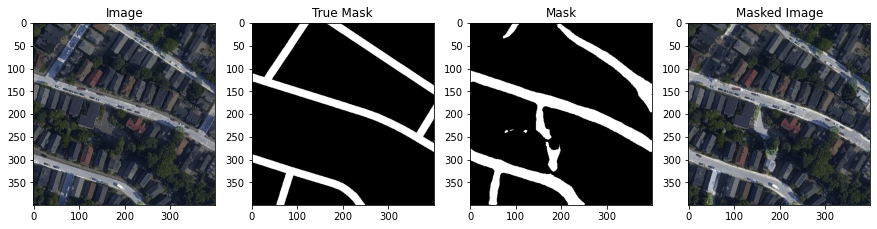

0.5600000023841858


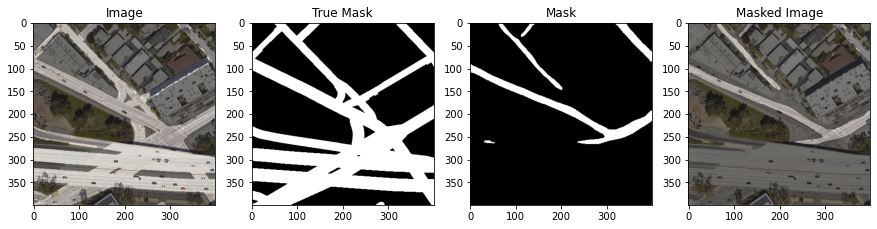

0.8144000172615051


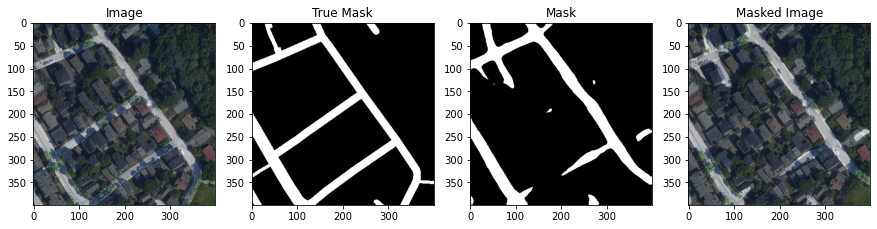

0.7296000123023987


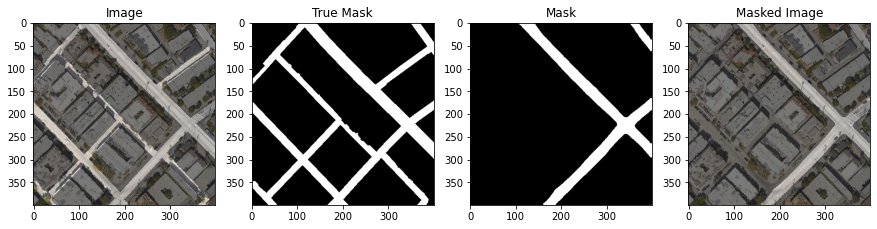

0.8447999954223633


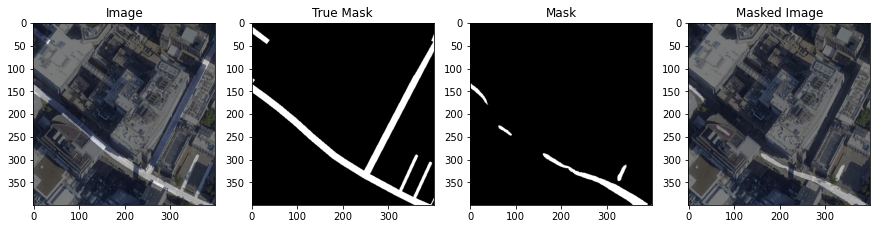

0.8543999791145325


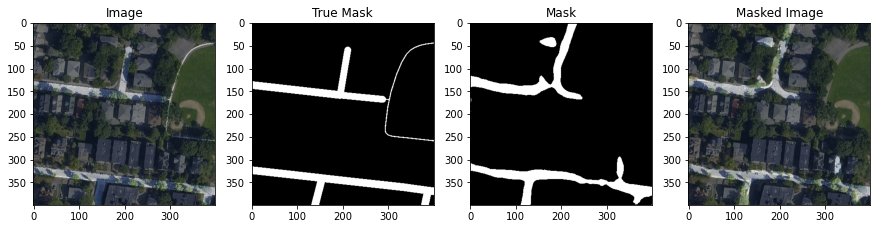

0.6848000288009644


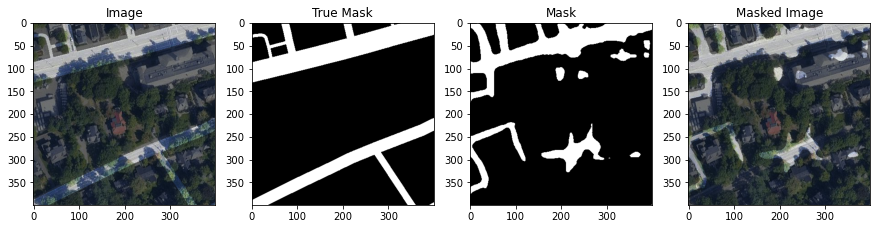

0.6912000179290771


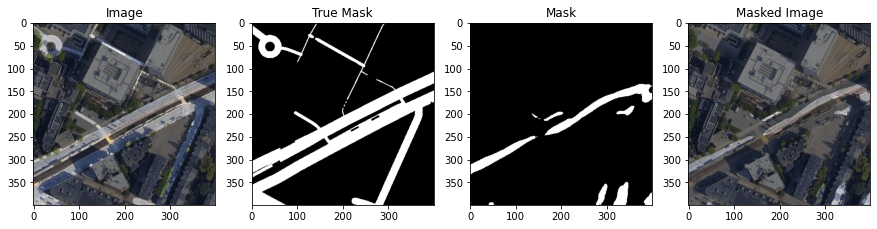

0.7936000227928162


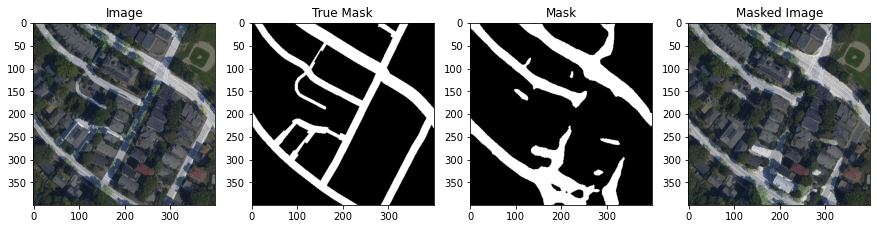

0.876800000667572


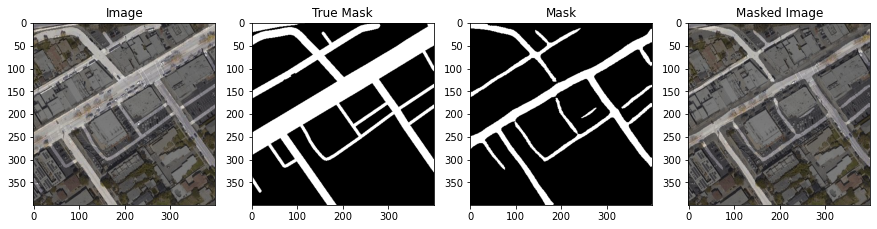

0.6111999750137329


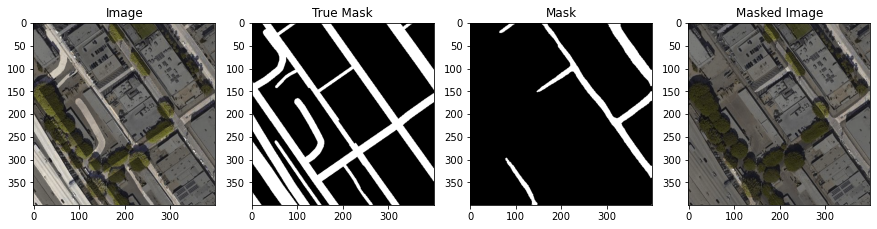

0.9455999732017517


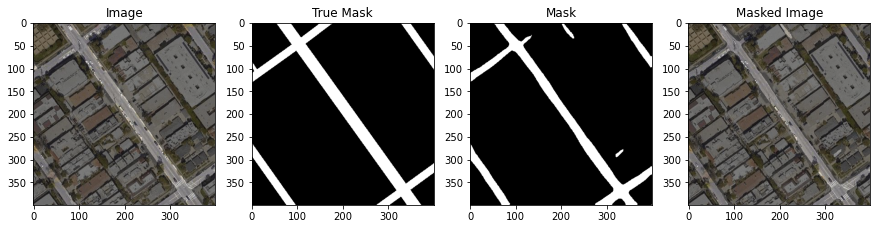

0.7936000227928162


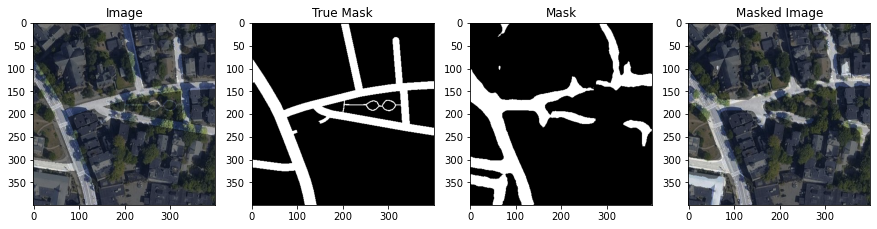

0.8320000171661377


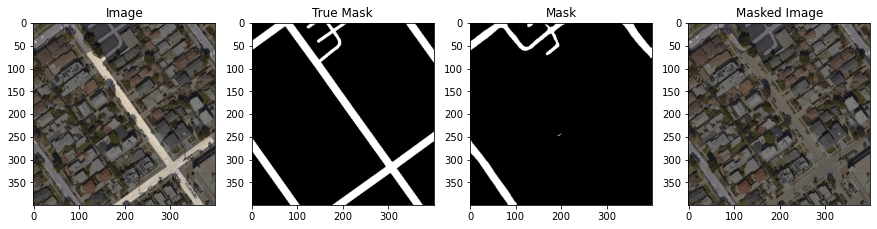

0.9391999840736389


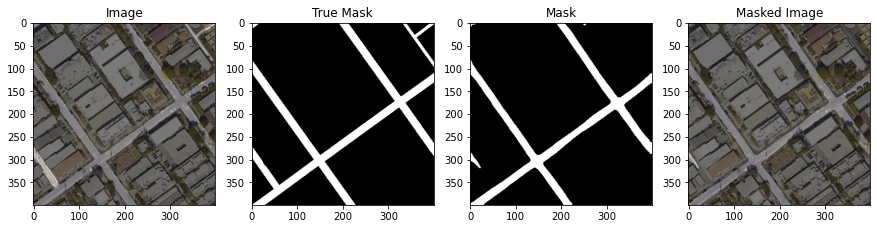

0.8784000277519226


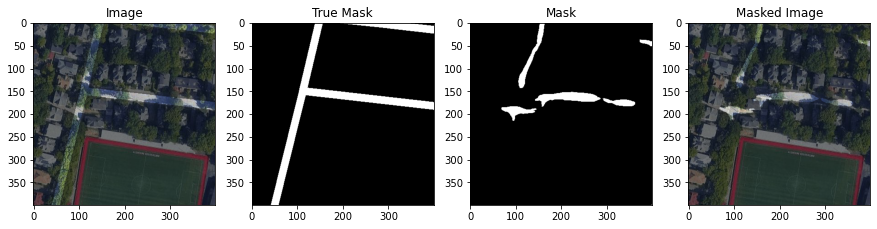

0.7648000121116638


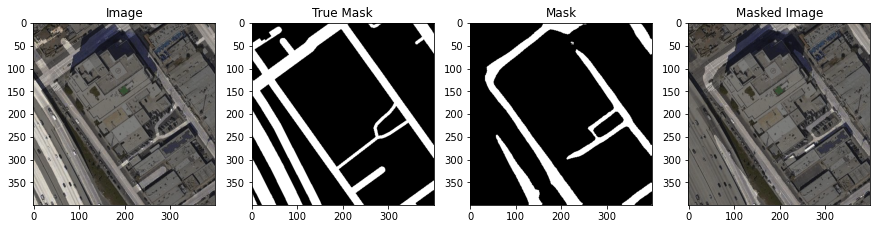

0.9103999733924866


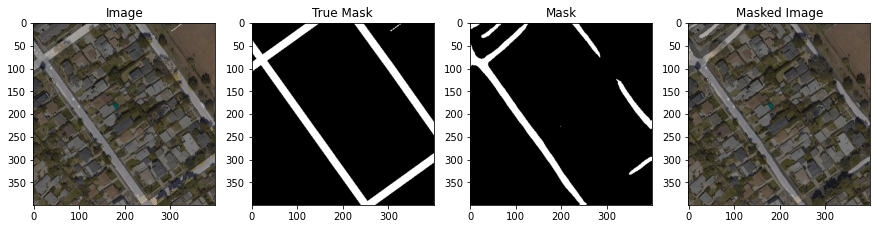

0.7487999796867371


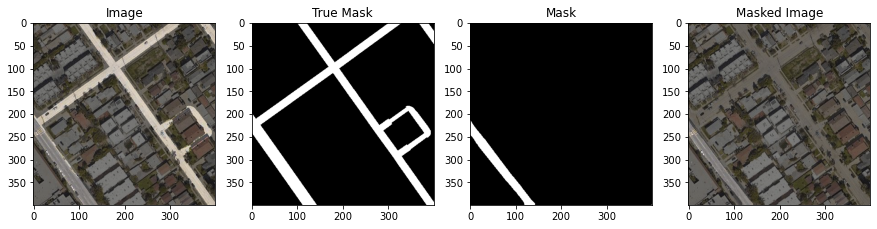

0.800000011920929


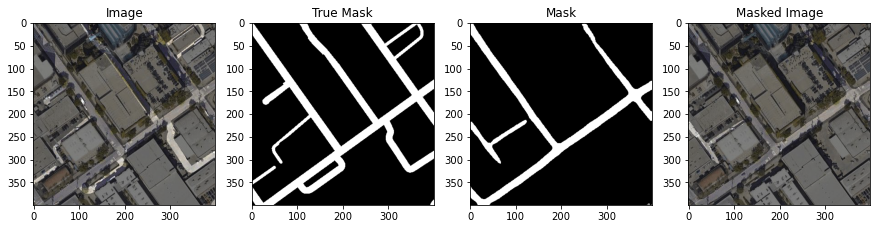

0.7807999849319458


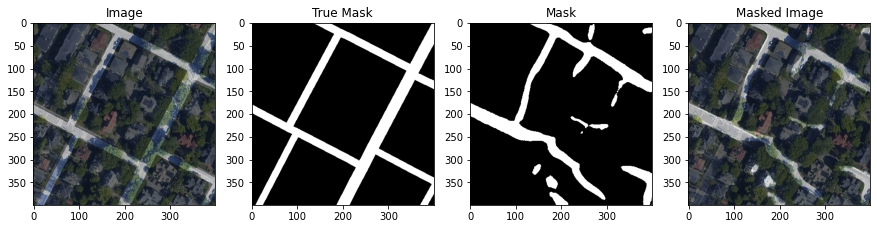

0.7871999740600586


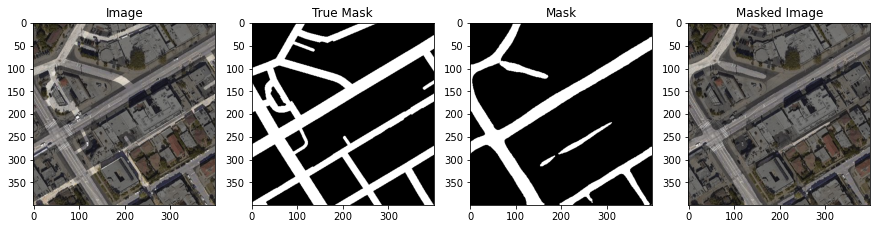

0.7824000120162964


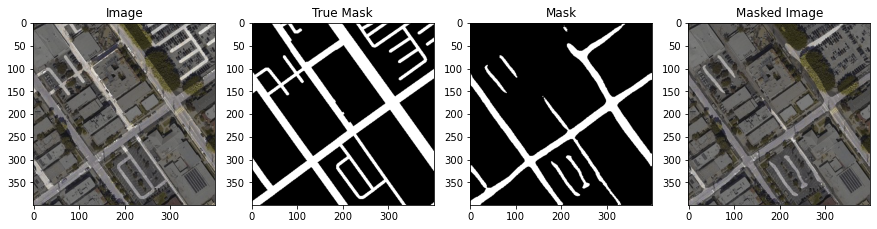

0.9088000059127808


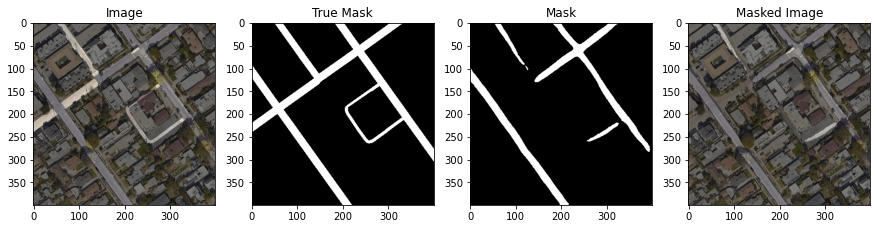

0.7103999853134155


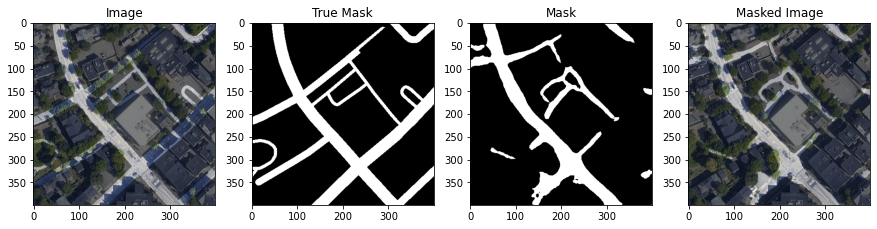

tensor(0.7915)

In [193]:
fnames = val_df["filename"].values

score = 0
for fname in (fnames):
    img = Image.open(os.path.join(img_path, "images", f"{fname}.jpg"))
    mask = Image.open(os.path.join(img_path, "groundtruth", f"{fname}-mask.png")).convert("L")
    mask = np.array(mask)
    img = np.array(img)

    
    img_tens = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
    img_tens = normalize_img(img_tens)
    with torch.no_grad():
        pred_mask = model(img_tens)[0][-1].softmax(axis=1).argmax(axis=1)[0, :, :].numpy() * 255.0

    mask = torch.tensor(mask, dtype=torch.float32)
    pred_mask = torch.tensor(pred_mask, dtype=torch.float32)

    pa = patch_accuracy_fn(pred_mask, mask)
    print(pa.item())
    plot_inference(model, img, np.array(mask))
    score += pa / len(fnames)

score


# Load Test Images

In [63]:
img_path = "/Users/alexanderveicht/Desktop/Coding/cil-road-segmentation.nosync/data/CIL-dataset/test/images" # test images
fnames = os.listdir(img_path)

fnames[:5]

['satimage_250.png',
 'satimage_244.png',
 'satimage_278.png',
 'satimage_287.png',
 'satimage_286.png']

satimage_250.png


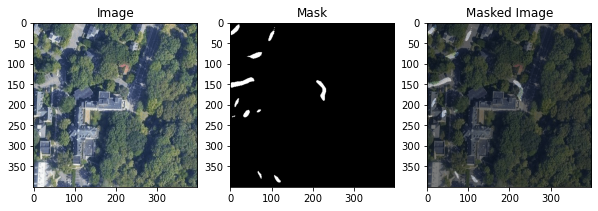

satimage_244.png


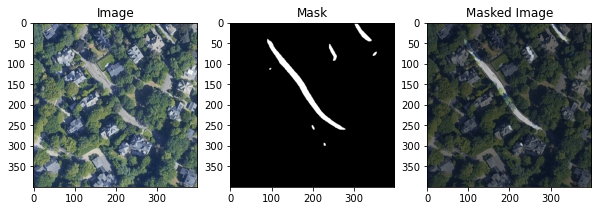

satimage_278.png


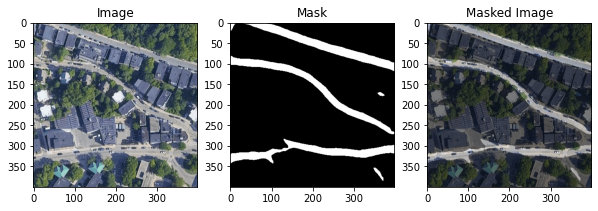

satimage_287.png


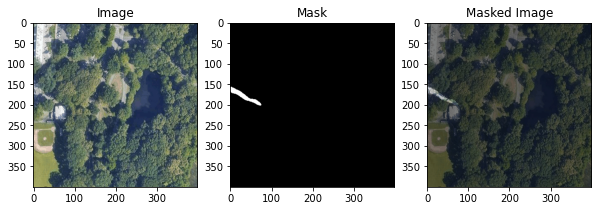

satimage_286.png


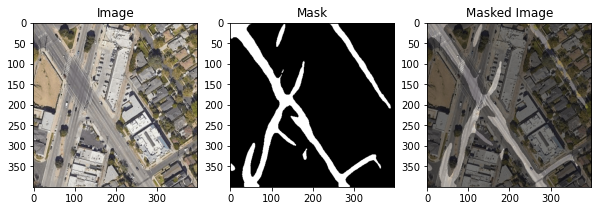

satimage_279.png


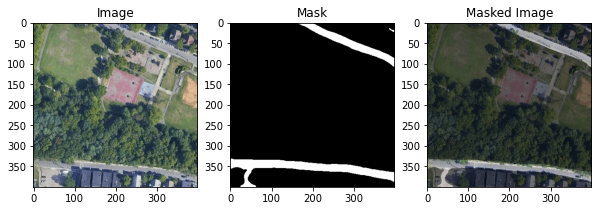

satimage_245.png


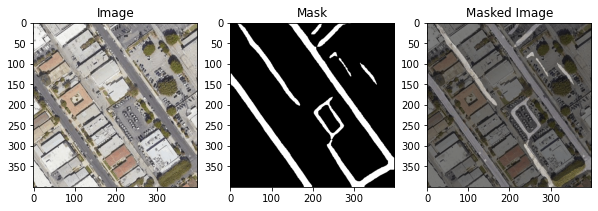

satimage_251.png


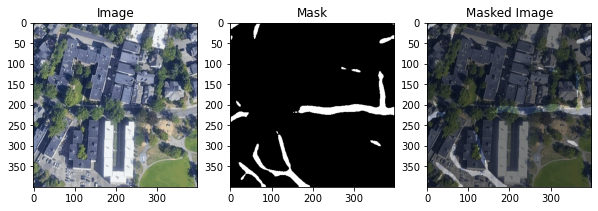

satimage_247.png


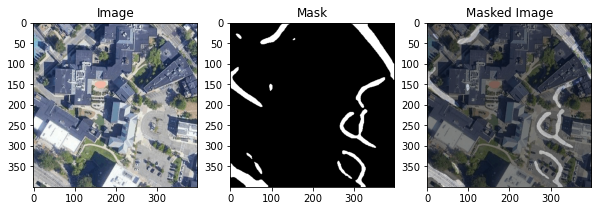

satimage_253.png


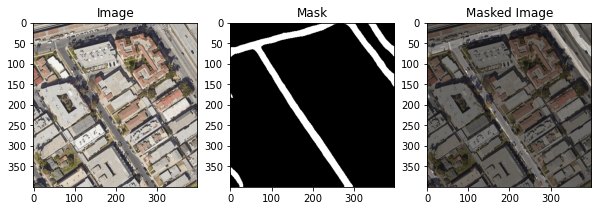

satimage_284.png


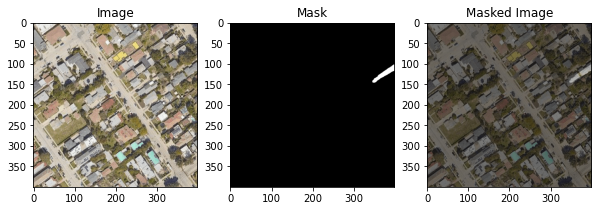

satimage_285.png


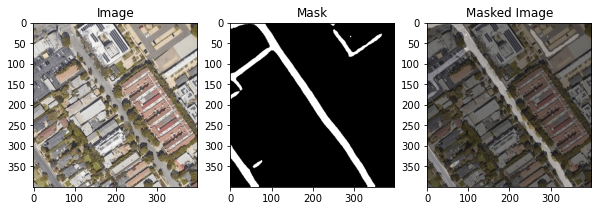

satimage_252.png


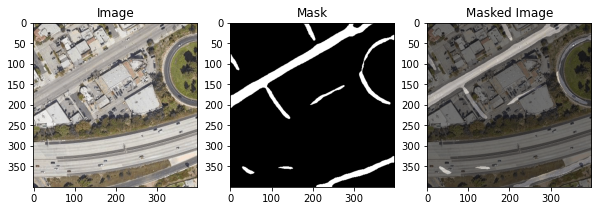

satimage_246.png


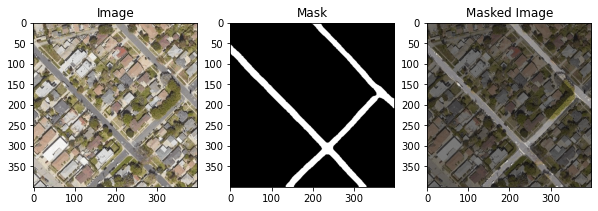

satimage_242.png


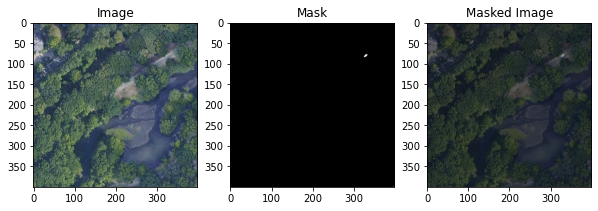

satimage_256.png


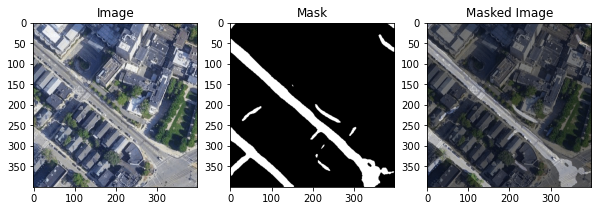

satimage_281.png


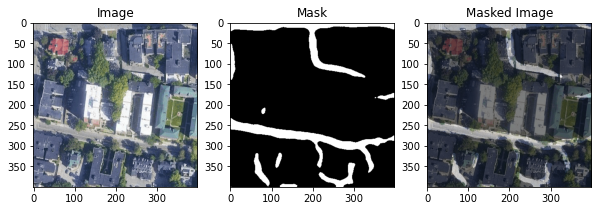

satimage_280.png


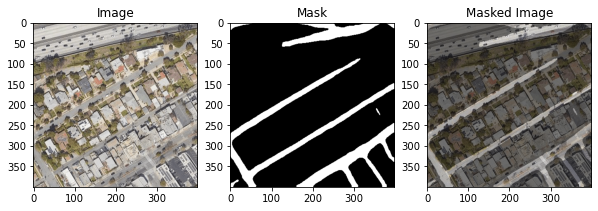

satimage_257.png


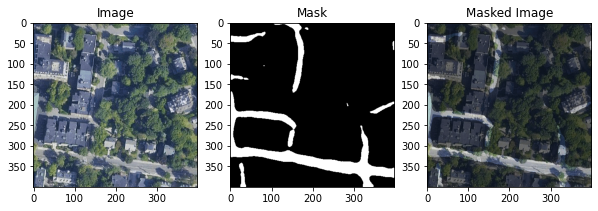

satimage_243.png


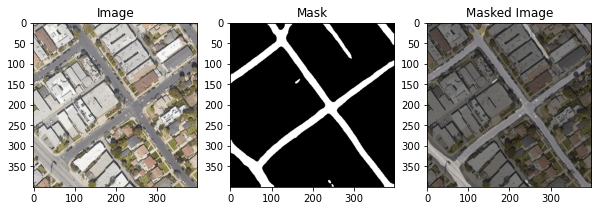

In [64]:
for idx in range(20):
    img = Image.open(os.path.join(img_path, fnames[idx])).convert("RGB")
    img = np.array(img)
    print(fnames[idx])
    plot_inference(model, img)

In [65]:
save_dir = "/Users/alexanderveicht/Desktop/Coding/cil-road-segmentation.nosync/data/CIL-dataset/test/predictions"
for idx in tqdm(range(len(fnames))):
    img = Image.open(os.path.join(img_path, fnames[idx])).convert("RGB")
    img = np.array(img)

    save_inference(model, img, os.path.join(save_dir, fnames[idx]))

100%|██████████| 144/144 [01:22<00:00,  1.75it/s]
